In [1]:
%connect --baudrate=115200 /dev/ttyACM0

Connected on /dev/ttyACM0


* Needs `pip3 install jypter-micropython-remote` [not forgetting](https://gitlab.com/alelec/jupyter_micropython_remote/-/issues/6) `python3 -m mpy_kernel.install` afterwards

The panel is [Waveshare 2.8inch Touch Display Module for Raspberry pi Pico, 320×240, SPI](https://www.waveshare.com/Pico-ResTouch-LCD-2.8.htm); resources are linked [from their Wiki page](https://www.waveshare.com/wiki/Pico-ResTouch-LCD-2.8), esp. the [Example code](https://www.waveshare.com/w/upload/f/fc/Pico-ResTouch-LCD-X_X_Code.zip) which contrary to claims contains no Micropython code.

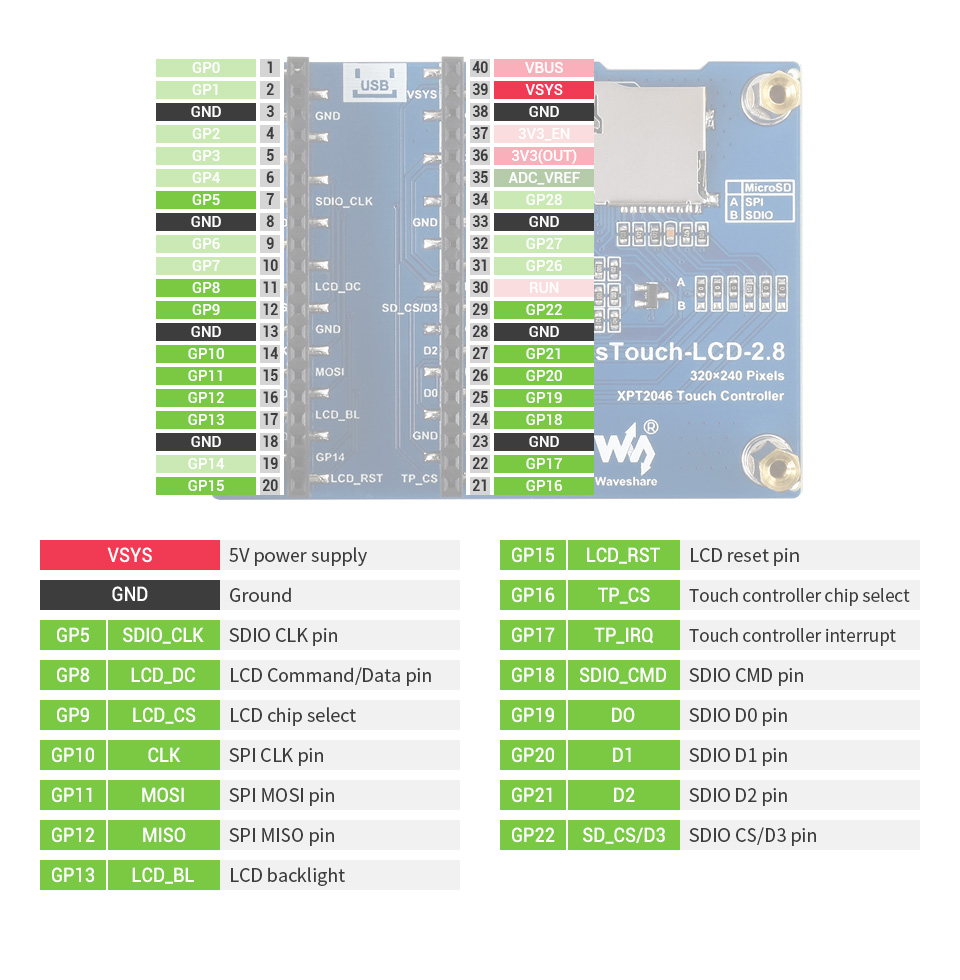

In [1]:
# this is taken from from Waveshare's
# Pico-ResTouch-LCD-X_X_Code/c/examples/DEV_Config.h
#
LCD_RST_PIN=15
LCD_DC_PIN=8 # jgpeiro: 14
LCD_CS_PIN=9
LCD_CLK_PIN=10
LCD_BKL_PIN=13 # jgpeiro: 15
LCD_MOSI_PIN=11
LCD_MISO_PIN=12
TP_CS_PIN=16
TP_IRQ_PIN=17
SD_CS_PIN=22

In [1]:
import machine
machine.freq( 200_000_000 )
print( "done" )

done


In [1]:
import time
import uctypes

class DMA:
    DMA_BASE  = 0x50000000
    
    DMA_EN    = 0x01 << 0
    HIGH_PRIO = 0x01 << 1
    INCR_READ = 0x01 << 4
    INCR_WRITE= 0x01 << 5
    DREQ_PIO0_RX0 = 0x04 << 15
    DREQ_SPI1_TX  = 0x12 << 15
    DREQ_PERMANENT= 0x3F << 15
    IRQ_QUIET = 0x01 << 21
    BUSY      = 0x01 << 24
    
    def __init__( self, channelNumber ):
        offset = channelNumber * 0x40
        self.CHx_READ_ADDR     = DMA.DMA_BASE + 0x00 + offset
        self.CHx_WRITE_ADDR    = DMA.DMA_BASE + 0x04 + offset
        self.CHx_TRANS_COUNT   = DMA.DMA_BASE + 0x08 + offset
        self.CHx_CTRL_TRIG     = DMA.DMA_BASE + 0x0C + offset
    
    def config( self, src_addr, dst_addr, count, src_inc, dst_inc, trig_dreq ):
        machine.mem32[ self.CHx_CTRL_TRIG ]   = 0
        machine.mem32[ self.CHx_READ_ADDR ]   = src_addr
        machine.mem32[ self.CHx_WRITE_ADDR ]  = dst_addr
        machine.mem32[ self.CHx_TRANS_COUNT ] = count
        trig_val = 0
        if( src_inc ):
            trig_val |= DMA.INCR_READ
        if( dst_inc ):
            trig_val |= DMA.INCR_WRITE
        trig_val |= trig_dreq
        machine.mem32[ self.CHx_CTRL_TRIG ]   = trig_val
    
    def enable( self ):
        machine.mem32[ self.CHx_CTRL_TRIG ] |= DMA.DMA_EN
    
    def disable( self ):
        machine.mem32[ self.CHx_CTRL_TRIG ] = 0
    
    def is_busy( self ):
        if( machine.mem32[ self.CHx_CTRL_TRIG ] & DMA.BUSY ):
            return True
        else:
            return False

def test_dma():
    dma = DMA(0)
    src_buf = b"Hello World!"*1000
    dst_buf = bytearray( 12*1000 )
    
    dma.config( 
        src_addr = uctypes.addressof( src_buf ), 
        dst_addr = uctypes.addressof( dst_buf ),
        count = len( src_buf ), 
        src_inc = True, 
        dst_inc = True, 
        trig_dreq = DMA.DREQ_PERMANENT 
    )

    t0 = time.ticks_us()
    dma.enable()
    while( dma.is_busy() ):
        pass
    dma.disable()
    t1 = time.ticks_us()

    print( "dst", dst_buf[0:12], "..." )

    print( "Transfer speed [B/s]:", len( src_buf )/((t1-t0)*1e-6) )
    print( "@CPU freq:", machine.freq() )

test_dma()

print( "done" )

dst bytearray(b'Hello World!') ...
Transfer speed [B/s]: 7.792208e+07
@CPU freq: 200000000
done


In [1]:
import time
import machine
import uctypes

class St7789:
    HRES = 320
    VRES = 240

    CASET = 0x2A
    RASET = 0x2B
    RAMWR = 0x2C 
    def __init__( self, baudrate, cs, sck, mosi, miso, dc ):
        self.buf1 = bytearray( 1 )
        self.buf2 = bytearray( 2 )
        self.buf4 = bytearray( 4 )
        
        self.baudrate = baudrate
        self.cs  = cs
        self.sck = sck
        self.mosi= mosi
        self.miso= miso
        self.dc  = dc

        self.cs.value( 1 )
        
        self.dma = DMA( 0 )
        self.spi_init()
        self.config()
    
    def spi_init( self ):
        self.spi = machine.SPI( 
            1, 
            baudrate=self.baudrate, 
            polarity=0,
            phase=0,
            sck=self.sck, 
            mosi=self.mosi, 
            miso=self.miso
        )
    
    def write_register( self, reg, buf ):
        self.buf1[0] = reg
        self.cs.value( 0 )

        self.dc.value( 0 )
        self.spi.write( self.buf1 )
        
        self.dc.value( 1 )
        self.spi.write( buf )
        
        self.cs.value( 1 )

    # Note: if is_blocking is False, user should call to wait_dma explicitly
    def write_register_dma( self, reg, buf, is_blocking=True ):    
        SPI1_BASE = 0x40040000
        SSPDR     = 0x008
        self.dma.config(
            src_addr = uctypes.addressof( buf ),
            dst_addr = SPI1_BASE + SSPDR,
            count    = len( buf ),
            src_inc  = True,
            dst_inc  = False,
            trig_dreq= DMA.DREQ_SPI1_TX
        )
        
        self.buf1[0] = reg
        self.cs.value( 0 )

        self.dc.value( 0 )
        self.spi.write( self.buf1 )
        
        self.dc.value( 1 )
        self.dma.enable()
        
        if( is_blocking ):
            self.wait_dma()

    def wait_dma( self ):
        while( self.dma.is_busy() ):
            pass
        self.dma.disable()
        
        # Note: wait to send last byte. It should take < 1uS @ 10MHz 
        time.sleep_us( 1 )
        
        self.cs.value( 1 )
    
    def config( self ):
        self.write_register( 0x11, b"" )
        time.sleep_ms( 100 )
        self.write_register( 0x36, b"\x60" )
        self.write_register( 0x3A, b"\x55" )
        self.write_register( 0xB2, b"\x0C\x0C\x00\x33\x33"  )
        self.write_register( 0xB7, b"\x35" )
        self.write_register( 0xBB, b"\x28" )
        self.write_register( 0xC0, b"\x3C" )
        self.write_register( 0xC2, b"\x01" )
        self.write_register( 0xC3, b"\x0B" )
        self.write_register( 0xC4, b"\x20" )
        self.write_register( 0xC6, b"\x0F" )
        self.write_register( 0xD0, b"\xA4\xA1" )
        self.write_register( 0xE0, b"\xD0\x01\x08\x0F\x11\x2A\x36\x55\x44\x3A\x0B\x06\x11\x20" )
        self.write_register( 0xE1, b"\xD0\x02\x07\x0A\x0B\x18\x34\x43\x4A\x2B\x1B\x1C\x22\x1F" )
        self.write_register( 0x55, b"\xB0" )
        self.write_register( 0x29, b"" )
        time.sleep_ms( 100 )

    def set_window( self, x, y, w, h ):
        x0 = x
        y0 = y
        x1 = x0 + w - 1
        y1 = y0 + h - 1
        self.buf4[0] = x0 >> 8
        self.buf4[1] = x0 &  0xff
        self.buf4[2] = x1 >> 8
        self.buf4[3] = x1 &  0xff
        self.write_register( St7789.CASET, self.buf4 )
        self.buf4[0] = y0 >> 8
        self.buf4[1] = y0 &  0xff
        self.buf4[2] = y1 >> 8
        self.buf4[3] = y1 &  0xff
        self.write_register( St7789.RASET, self.buf4 )
    
    def draw_bitmap_dma( self, x, y, w, h, buf, is_blocking=True ):
        self.set_window( x, y, w, h )
        self.write_register_dma( St7789.RAMWR, buf, is_blocking )
        
    def clear( self, color ):
        self.buf2[0] = color >> 8
        self.buf2[1] = color &  0xff
        
        self.set_window( 0, 0, St7789.HRES, St7789.VRES  )
        self.write_register( St7789.RAMWR, b"" )

        self.cs.value( 0 )
        self.dc.value( 1 )
        for i in range( St7789.HRES ):
            for j in range( St7789.VRES ):
                self.spi.write( self.buf2 )
        self.cs.value( 1 )

def build_square_buf( w, h ):
    top = b"\xFF\xFF"*w
    body=(b"\xFF\xFF" + b"\x00\x00"*(w-2) + b"\xFF\xFF")*(h-2)
    bot = b"\xFF\xFF"*w
    return top + body + bot
    
def test_lcd():
    baudrate = 24_000_000
    cs  = machine.Pin( LCD_CS_PIN, machine.Pin.OUT ) ## jgpeiro: 9
    sck = machine.Pin( LCD_CLK_PIN, machine.Pin.OUT )
    mosi= machine.Pin( LCD_MOSI_PIN, machine.Pin.OUT )
    miso= machine.Pin( LCD_MISO_PIN, machine.Pin.IN  )
    dc  = machine.Pin( LCD_DC_PIN, machine.Pin.OUT ) ## jgpeiro: 14

    bl  = machine.Pin( LCD_BKL_PIN, machine.Pin.OUT ) ## jgpeiro: 15
    bl.value( 1 )

    lcd = St7789( baudrate, cs, sck, mosi, miso, dc )
    lcd.clear( 0x001F )

    # 1/4 screen pixels square with white border red backgorund 
    w, h = 320//4, 240//4
    bmp = build_square_buf( w, h )
    
    t0 = time.ticks_us()
    lcd.draw_bitmap_dma( 100, 100, w, h, bmp )
    t1 = time.ticks_us()

    print( "Maximum FPS @24MHz:", 24e6/( 320*240*16 ) ) # FPS = F/(W*H*BPP)
    print( "Achieved FPS:", 1/(16*(t1-t0)*1e-6) )       # Note: Test only draws 1/16 of the sreen area
    
    print( "Draw TSC calibration pattern")
    w, h = 10, 10
    bmp = build_square_buf( w, h )
    lcd.draw_bitmap_dma( 50, 50, w, h, bmp )
    lcd.draw_bitmap_dma( 250, 50, w, h, bmp )
    lcd.draw_bitmap_dma( 250, 200, w, h, bmp )
    lcd.draw_bitmap_dma( 50, 200, w, h, bmp )

test_lcd()

print( "done" )

Maximum FPS @24MHz: 19.53125
Achieved FPS: 14.25964
Draw TSC calibration pattern
done


In [1]:
import time
import machine

class Xpt2046:
    
    CHANNEL_X = 0x90
    CHANNEL_Y = 0xD0
    
    def __init__( self, baudrate, cs, sck, mosi, miso, ax=1, bx=0, ay=1, by=0 ):
        self.buf_tx = bytearray( 3 )
        self.buf_rx = bytearray( 3 )
        
        self.sck = sck
        self.mosi= mosi
        self.miso= miso
        self.cs  = cs
        self.cs.value( 1 )

        self.ax = ax
        self.bx = bx
        self.ay = ay
        self.by = by
        
        self.baudrate = baudrate
        self.spi_init()

    
    def spi_init( self ):
        self.spi = machine.SPI( 
            1, 
            baudrate=self.baudrate, 
            polarity=0,
            phase=0,
            sck=self.sck, 
            mosi=self.mosi, 
            miso=self.miso 
        )

    def _read( self ):
        self.cs.value( 0 )
        
        self.buf_tx[0] = Xpt2046.CHANNEL_X
        self.buf_tx[1] = 0x00
        self.buf_tx[2] = 0x00
        self.spi.write_readinto( self.buf_tx, self.buf_rx )
        x = (self.buf_rx[1]<<4) | (self.buf_rx[2]>>4)

        self.buf_tx[0] = Xpt2046.CHANNEL_Y
        self.buf_tx[1] = 0x00
        self.buf_tx[2] = 0x00
        self.spi.write_readinto( self.buf_tx, self.buf_rx )
        y = (self.buf_rx[1]<<4) | (self.buf_rx[2]>>4)
        
        self.cs.value( 1 )
        
        if( x == 2047 ):
            x = 0
        
        return x, y

    def read( self ):
        xacc = 0
        yacc = 0
        for i in range( 4 ):
            x, y = self._read()
            if( x and y ):
                xacc += x
                yacc += y
            else:
                return 0, 0
        
        x = xacc/4
        y = yacc/4
        
        x = self.ax*x + self.bx
        y = self.ay*y + self.by
        
        return int( 320-x ), int( y )

def test_tsc():    
    baudrate= 1_000_000
    cs  = machine.Pin( TP_CS_PIN, machine.Pin.OUT )
    sck = machine.Pin( LCD_CLK_PIN, machine.Pin.OUT )
    mosi= machine.Pin( LCD_MOSI_PIN, machine.Pin.OUT )
    miso= machine.Pin( LCD_MISO_PIN, machine.Pin.OUT )

    # Calibration values
    AX = 0.176831
    BX =-45.643
    AY = 0.13084
    BY =-16.191

    tsc = Xpt2046( baudrate, cs, sck, mosi, miso, ax=AX, bx=BX, ay=AY, by=BY )
    for i in range( 10 ):
        x, y = tsc.read()
        if( x and y ):
            print( x, y )
        time.sleep( 1 )


test_tsc()

print("done")

done


In [1]:
import time
import machine
import lvgl as lv
import sys

# This leds shows when lcd is busy
dma_led = machine.Pin( 25, machine.Pin.OUT )

print( "lv.init()" )
lv.init()

print( "disp_buf_t.init()" )
HRES, VRES = 320, 240
fb1 = bytearray( HRES*64 )
fb2 = bytearray( HRES*64 )
disp_draw_buf = lv.disp_draw_buf_t()
disp_draw_buf.init( fb1, fb2, len( fb1 )//lv.color_t.__SIZE__ )

is_fb1 = True
dma_running = False
def disp_drv_flush_cb( disp_drv, area, color ):
    global is_fb1, dma_running
    #print( "disp_drv_flush_cb", area.x1, area.x2, area.y1, area.y2 )
    
    if( is_fb1 ):
        fb = memoryview( fb1 )
    else:
        fb = memoryview( fb2 )
    is_fb1 = not is_fb1
        
    if( dma_running == True ):
        lcd.wait_dma()
        dma_running = False
        dma_led.off()
    
    x = area.x1
    y = area.y1
    w = area.x2 - area.x1 + 1
    h = area.y2 - area.y1 + 1
    # FIXME: check that data have the correct size (LV_COLOR_DEPTH)
    lcd.draw_bitmap_dma( x, y, w, h, fb[0:2*w*h], is_blocking=False )
    dma_running = True
    dma_led.on()
    
    disp_drv.flush_ready()


print( "disp_drv_t.init()" )
disp_drv = lv.disp_drv_t()
disp_drv.init()
disp_drv.draw_buf = disp_draw_buf
disp_drv.flush_cb = disp_drv_flush_cb
disp_drv.hor_res = HRES
disp_drv.ver_res = VRES
disp_drv.register()

xx, yy, ss = 0, 0, 0
def indev_drv_read_cb( indev_drv, data ):
    global xx, yy, ss, dma_running
    #print( "indev_drv_read_cb" )
    
    if( dma_running == True ):
        lcd.wait_dma()
        dma_running = False
        dma_led.off()        
    
    tsc.spi_init()
    x, y = tsc.read()
    lcd.spi_init() # Reinit SPI with LCD settings
    
    if( x or y ):
        xx = x
        yy = y
        ss = 1
    else:
        ss = 0
    
    data.state = ss
    data.point.x = xx
    data.point.y = yy
    return False

print( "indev_drv_t.init()" )
indev_drv = lv.indev_drv_t()
indev_drv.init()
indev_drv.type = lv.INDEV_TYPE.POINTER
indev_drv.read_cb = indev_drv_read_cb
indev_drv.register()

#def cb_lv_log( msg ):
#    print( msg, end="" )
#lv.log_register_print_cb( cb_lv_log )

print( "lv_run" )
def lv_run( timeout_ms=1000, period_ms=10 ):
    t0 = time.ticks_ms()
    while( time.ticks_diff( time.ticks_ms(), t0 ) < timeout_ms ):
        tt0 = time.ticks_ms()
        lv.task_handler()
        tt1 = time.ticks_ms()
        dt = tt1-tt0
        
        if( period_ms > dt ):
            time.sleep_ms( period_ms - dt )
            lv.tick_inc( period_ms )
        else:
            lv.tick_inc( dt )

print("done")

lv.init()
disp_buf_t.init()
disp_drv_t.init()
indev_drv_t.init()
lv_run
done


In [1]:
lcd_baudrate = 24_000_000
tsc_baudrate = 1_000_000

lcd_cs  = machine.Pin( LCD_CS_PIN, machine.Pin.OUT )
tsc_cs  = machine.Pin( TP_CS_PIN, machine.Pin.OUT )

sck = machine.Pin( LCD_CLK_PIN, machine.Pin.OUT )
mosi= machine.Pin( LCD_MOSI_PIN, machine.Pin.OUT )
miso= machine.Pin( LCD_MISO_PIN, machine.Pin.IN  )
dc  = machine.Pin( LCD_DC_PIN, machine.Pin.OUT )

bl  = machine.Pin( LCD_BKL_PIN, machine.Pin.OUT )
bl.value( 1 )


rst=machine.Pin(LCD_RST_PIN,machine.Pin.OUT)
rst.value(0)
time.sleep_ms(500)
rst.value(1)
time.sleep_ms(500)


# Calibration values
AX, BX = 0.176831, -45.643
AY, BY = 0.130840, -16.191
tsc = Xpt2046( tsc_baudrate, tsc_cs, sck, mosi, miso, ax=AX, bx=BX, ay=AY, by=BY )

# Init lcd last one to start lvgl with SPI LCD baudrate
lcd = St7789( lcd_baudrate, lcd_cs, sck, mosi, miso, dc )
lcd.clear( 0x0000 )

print( "done" )

done


In [1]:
def cb_btn( event ):
    print( "Hello World!" )

scr = lv.obj()
btn = lv.btn( scr )
lbl = lv.label( btn )
lbl.set_text( "Press me!" )
btn.center()

btn.add_event_cb( cb_btn, lv.EVENT.CLICKED, None )

lv.scr_load( scr )

lv_run( 10_000 )

print( "done" )

Hello World!
Hello World!
done
